In [2]:
import os
import dill as pickle
import PDielec.UnitCell as UnitCell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.structure_matcher import StructureMatcher
from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint

In [3]:
class AtomicShift:
    
    def __init__(self, pickle_file=None, readers=[], struct_start=None, struct_end=None, ase_start=None, ase_end=None, 
                fp_start=None, fp_end=None, coords_df_list=[], labelled_coords_df=None, nonH_df=[], nonH_names_s = None):
        self.pickle_file = pickle_file
        self.readers = readers
        self.struct_start = struct_start
        self.struct_end = struct_end
        self.ase_start = ase_start
        self.ase_end = ase_end
        self.fp_start = fp_start
        self.fp_end = fp_end
        self.coords_df_list = coords_df_list
        self.labelled_coords_df = labelled_coords_df
        self.nonH_df = nonH_df
        self.nonH_names_s = nonH_names_s
        
    def read_pickle_file(self, pickle_file):
        with open(pickle_file, 'rb') as f:
            self.readers = pickle.load(f)
            f.close()
    
    def convert_to_pymatgen_ase(self):
        self.struct_start = Structure(self.readers.unit_cells[0].lattice, 
                                      self.readers.unit_cells[0].element_names, 
                                      self.readers.unit_cells[0].fractional_coordinates)
        self.atoms_start  = AseAtomsAdaptor.get_atoms(self.struct_start)
        self.struct_end = Structure(self.readers.unit_cells[-1].lattice, 
                                    self.readers.unit_cells[-1].element_names, 
                                    self.readers.unit_cells[-1].fractional_coordinates)
        self.atoms_end  = AseAtomsAdaptor.get_atoms(self.struct_end)
        
    def start_end_structure_matcher(self):
        SM = StructureMatcher()
        struct_fit = SM.fit(self.struct_start, self.struct_end)
        rms = SM.get_rms_dist(self.struct_start, self.struct_end)
        
        return [struct_fit, rms]

    def generate_fingerprint(self):
        ssf = SiteStatsFingerprint(CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None),stats=('mean', 'maximum'))
        self.fp_start = np.array(ssf.featurize(self.struct_start))
        self.fp_end = np.array(ssf.featurize(self.struct_end))
        
    def start_end_comparison_metrics(self):
        eu_dist = '{:.4f}'.format(np.linalg.norm(self.fp_start - self.fp_end))
        dot_prod = '{:.4f}'.format(np.dot(self.fp_start, self.fp_end) ** 0.5)
        cos_sim = '{:.4f}'.format(np.dot(self.fp_start, self.fp_end)/
                                  (np.linalg.norm(self.fp_start)*np.linalg.norm(self.fp_end)))
        mod_cos_sim = '{:.4f}'.format(np.dot(self.fp_start, self.fp_end)/
                                      np.maximum(np.linalg.norm(self.fp_start),np.linalg.norm(self.fp_end)) ** 2)
            
        return eu_dist, dot_prod, cos_sim, mod_cos_sim
    
    def make_dfs(self):
        step = 0
        while step < len(self.readers.unit_cells):
            names_df = pd.Series(self.readers.unit_cells[step].element_names, name='Element')
            coords_df = pd.DataFrame(self.readers.unit_cells[step].xyz_coordinates)
            self.coords_df_list.append(coords_df)
            self.labelled_coords_df = coords_df
            self.labelled_coords_df = self.labelled_coords_df.rename(columns={0:'x', 1:'y', 2:'z'})
            self.labelled_coords_df["Element"] = names_df
            step += 1

    def rmsd_step(self):
        step = 2
        rms_df = self.coords_df_list[step-1] - self.coords_df_list[step]
        N = self.readers.nions
        rms_df[3] = ((((rms_df[0] ** 2) + (rms_df[1] ** 2) + (rms_df[2] ** 2))/ N) ** 0.5)
        
        return rms_df
    
    def create_nonH_df(self):
        # Variables
        names = self.readers.unit_cells[0].element_names
        nonH_index = []
        rmslist = []
        c1 = 0
        c2 = 0
        
        # Make nonH list of names
        for i in names:
            if i != 'H':   
                nonH_index.append(c1)
            c1+=1
        ssfull = self.readers.unit_cells[0].xyz_coordinates
        ss = self.readers.unit_cells[0].xyz_coordinates[nonH_index[0]:nonH_index[-1]+1]
        es = self.readers.unit_cells[-1].xyz_coordinates[nonH_index[0]:nonH_index[-1]+1]
        
        # Make RMS list
        while c2 < len(ss):
            diff = ss[c2] - es[c2]
            N = len(ss)
            rms = np.sqrt((diff * diff).sum() / N)
            rmslist.append(rms)
            c2+=1
        
        # Make nonH df
        nonH_names = names[nonH_index[0]:(nonH_index[-1]+1)]
        c3 = 0
        nonH_rmsd = []
        while c3 < len(rmslist):
            nonH_rmsd.append([nonH_names[c3], rmslist[c3]])
            c3+=1
        self.nonH_names_s = list(dict.fromkeys(nonH_names))
        rms_dict = dict.fromkeys(self.nonH_names_s)

        new_dict = {i: [] for i in self.nonH_names_s}
        for i in nonH_rmsd:
            new_dict[i[0]].append(i[1])

        for i in self.nonH_names_s:
            self.nonH_df.append(pd.DataFrame(new_dict[i]))
            self.nonH_df[-1].columns = [i]
            
    def violin_plot_nonH(self):
        sns.set(rc={"font.size":35,"axes.titlesize":35,"axes.labelsize":35, "ytick.labelsize":35})
        palette = cycle(sns.color_palette("hls", 8))

        fig, ax = plt.subplots(1, 2, figsize=(20, 20))
        
        c1 = 0
        for i in self.nonH_df: 
            sns.violinplot(data=i, ax=ax.flat[c1], bw=0.25, color=next(palette)).set_title(self.nonH_names_s[c1])
            c1+=1 
        plt.show()
        
class DirectComparison:
    
    def __init__(self, struct1_pymat=None, struct2_pymat=None, struct1_fp=None, struct2_fp=None, 
                       struct1_ase=None, struct2_ase=None):
        self.struct1_pymat = struct1_pymat
        self.struct2_pymat = struct2_pymat
        self.struct1_fp = struct1_fp
        self.struct2_fp = struct2_fp
        self.struct1_ase = struct1_ase
        self.struct2_ase = struct2_ase

        
    def start_end_structure_matcher(self):
        SM = StructureMatcher()
        struct_fit = SM.fit(self.struct1_pymat, self.struct2_pymat)
        rms = SM.get_rms_dist(self.struct1_pymat, self.struct2_pymat)
        
        return [struct_fit, rms]

    def start_end_comparison_metrics(self):
        eu_dist = '{:.4f}'.format(np.linalg.norm(self.struct1_fp - self.struct2_fp))
        dot_prod = '{:.4f}'.format(np.dot(self.struct1_fp, self.struct2_fp) ** 0.5)
        cos_sim = '{:.4f}'.format(np.dot(self.struct1_fp, self.struct2_fp)/
                                  (np.linalg.norm(self.struct1_fp)*np.linalg.norm(self.struct2_fp)))
        mod_cos_sim = '{:.4f}'.format(np.dot(self.struct1_fp, self.struct2_fp)/
                                      np.maximum(np.linalg.norm(self.struct1_fp),np.linalg.norm(self.struct2_fp)) ** 2)
            
        return eu_dist, dot_prod, cos_sim, mod_cos_sim
    
    def violin_plot_compare(self):
        # Create df of both runs
        comparison_d
        
        ax = sns.violinplot(x="day", y="total_bill", hue="smoker",
                    data=tips, palette="muted", split=True)

In [4]:
# picklefile = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D3\\MULTIOUTCAR\\D3_cat.pickle'
picklefile2 = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\TS\\TS_cat.pickle'

# D3 = AtomicShift()
# D3.read_pickle_file(picklefile)
# D3.create_nonH_df()
# D3.violin_plot_nonH()

TS = AtomicShift()
TS.read_pickle_file(picklefile2)
TS.create_nonH_df()

In [6]:
newlist = []
# newlist.append(D3.nonH_df[0])
# newlist.append(D3.nonH_df[1])
newlist.append(TS.nonH_df[0])
newlist.append(TS.nonH_df[1])

newdf = pd.concat([TS.nonH_df[0], TS.nonH_df[1]], axis=1)# D3BJ.nonH_df[0], D3BJ.nonH_df[1]], axis=1)
# newdf.rename(columns={'C':'Shift', 'O':'Shift'})
# newdf['Element'] = 'C'
newdf.to_excel('test3.xlsx')
testdf = pd.read_excel('ViolinPlotTest.xlsx')
testdf

,Element,Shift,Correction
0,C,0.012315,D3
1,C,0.016735,D3
2,C,0.018747,D3
3,C,0.023349,D3
4,C,0.019921,D3
...,...,...,...
91,O,0.013302,TS
92,O,0.018110,TS
93,O,0.012660,TS
94,O,0.019446,TS


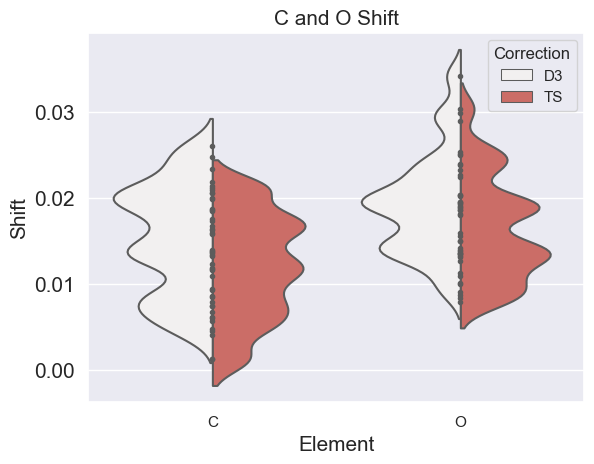

In [7]:
sns.set(rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15, "ytick.labelsize":15})
palette = cycle(sns.color_palette("hls", 8))
ax = sns.violinplot(data=testdf, x='Element', y='Shift', hue='Correction', bw=0.25, 
                    color=next(palette), split=True, inner='point').set_title('C and O Shift')
plt.show()

# Need to figure out how to make dataframe containing both C and O from each correction, then hue will work

In [8]:
picklefile1 = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D2TestFiles\\Concatenated\\D2_cat.pickle'
picklefile2 = 'C:\\Users\\Calum\\Documents\\Coding\\Python\\PDielec_Dev\\PDielec\\IVDWFiles\\D3BJ\\D3BJ_cat.pickle'

# Reads file for D2 Calculation, produces structures and metrics between start and end.
D2 = AtomicShift()
D2.read_pickle_file(picklefile1)
D2.convert_to_pymatgen_ase() # produces pymatgen and ase structures
D2rms = D2.start_end_structure_matcher() # provides True/False, RMS and Mapping
D2.generate_fingerprint() # produces crystal fingerprint, takes some time
D2metrics = D2.start_end_comparison_metrics() # generates comparison metrics based on fingerprint, 
                                           # needs generate_fingerprint() to happen

print(D2rms)
print(D2metrics)

[True, (0.06892685520608857, 0.12881647713445976)]
('0.3580', '2.2078', '0.9883', '0.9390')


In [4]:
# Reads file for D3BJ Calculation, produces structures and metrics between start and end.
D3BJ = AtomicShift()
D3BJ.read_pickle_file(picklefile2)
D3BJ.convert_to_pymatgen_ase()
D3BJrms = D3BJ.start_end_structure_matcher()
D3BJ.generate_fingerprint()
D3BJmetrics = D3BJ.start_end_comparison_metrics()

print(D3BJrms)
print(D3BJmetrics)

[True, (0.07594254332272038, 0.15716333849175604)]
('0.3496', '2.2088', '0.9889', '0.9393')


In [6]:
# Takes previously calculated final structures for D2 and D3BJ and compares them in the same way as above.
D2_D3BJ = DirectComparison(D2.struct_end, D3BJ.struct_end, D2.fp_end, D3BJ.fp_end)
D2_D3BJrms = D2_D3BJ.start_end_structure_matcher()
D2_D3BJmetrics = D2_D3BJ.start_end_comparison_metrics()

print(D2_D3BJrms)
print(D2_D3BJmetrics)

[True, (0.03729685698123244, 0.07334519644715518)]
('0.0586', '2.2783', '0.9997', '0.9994')
